# Full Dependencies Analysis
This notebook explores the recursive dependencies exported in full_dataset_dependencies.json

Requirements: install networkx, matplotlib and ipywidgets via pip

## Important
Install nbstripout via pip and run command: nbstripout --install to ensure that outputs from this workbook are not synced to git

## Setup and Load

In [10]:
import json
import matplotlib.pyplot as plt
import pandas as pd

INPUT_FILE_NAME = "full_dataset_dependencies.json"
INPUT_DIR = "Output"

# Load the direct dependencies data
file_path = f"{INPUT_DIR}/{INPUT_FILE_NAME}"
with open(file_path, 'r') as file:
    full_dependencies = json.load(file)

# Convert to a DataFrame
dependency_list = []
for dataset, dependencies in full_dependencies.items():
    for dep in dependencies:
        dependency_list.append({"Dataset": dataset, "Dependency": dep})

df = pd.DataFrame(dependency_list)


## Basic Data Exploration

In [11]:
# Display the first few rows of the DataFrame
print(df.head())

                  Dataset                       Dependency
0  ICB_LTC_CF_TIME_SERIES   CERNER_MEDICATION_JOINED_TABLE
1  ICB_LTC_CF_TIME_SERIES  CERNER_ETHNICITY_SECONDARY_CARE
2  ICB_LTC_CF_TIME_SERIES                PH_D_PERSON_EMAIL
3  ICB_LTC_CF_TIME_SERIES                     ASTHMA_CHILD
4  ICB_LTC_CF_TIME_SERIES                   PH_F_CARE_TEAM


In [12]:
# DataFrame shape (number of rows and columns)
print(f"DataFrame Shape: {df.shape}")

# Column data types
print(f"Data Types:\n{df.dtypes}")

# Check for missing values
missing_values = df.isnull().sum()
print(f"Missing Values:\n{missing_values}")


DataFrame Shape: (56457, 2)
Data Types:
Dataset       object
Dependency    object
dtype: object
Missing Values:
Dataset       0
Dependency    0
dtype: int64


## Unique Dataset Count

In [13]:
# Unique Datasets and Dependencies
unique_datasets = df['Dataset'].nunique()
unique_dependencies = df['Dependency'].nunique()
print(f"Unique Datasets: {unique_datasets}")
print(f"Unique Dependencies: {unique_dependencies}")

Unique Datasets: 883
Unique Dependencies: 1371


## Frequent dependencies

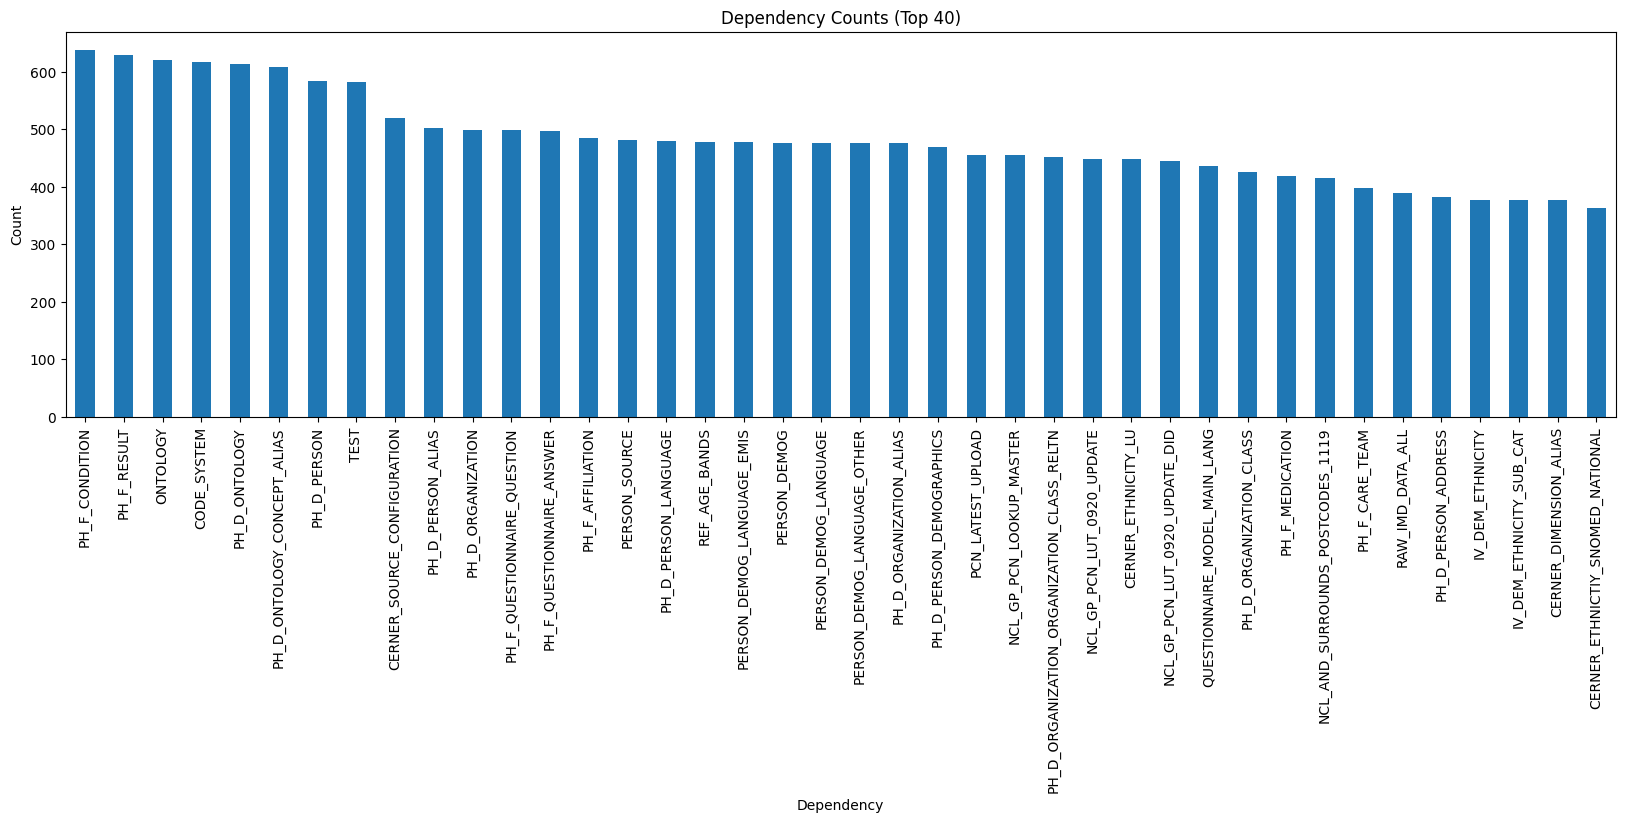

In [14]:
dependency_freq = df['Dependency'].value_counts().head(40)

plt.figure(figsize=(20, 5))
dependency_freq.plot(kind='bar')
plt.xlabel('Dependency')
plt.ylabel('Count')
plt.title('Dependency Counts (Top 40)')

# Set x-axis tick labels and rotation
plt.xticks(rotation=90)

# Show the plot
plt.show()


In [15]:
# Frequency of dependencies
dependency_freq = df['Dependency'].value_counts().head(20)
print("Most frequent dependencies:\n", dependency_freq)

Most frequent dependencies:
 Dependency
PH_F_CONDITION                 638
PH_F_RESULT                    630
ONTOLOGY                       621
CODE_SYSTEM                    618
PH_D_ONTOLOGY                  613
PH_D_ONTOLOGY_CONCEPT_ALIAS    608
PH_D_PERSON                    584
TEST                           582
CERNER_SOURCE_CONFIGURATION    520
PH_D_PERSON_ALIAS              503
PH_D_ORGANIZATION              499
PH_F_QUESTIONNAIRE_QUESTION    499
PH_F_QUESTIONNAIRE_ANSWER      497
PH_F_AFFILIATION               485
PERSON_SOURCE                  482
PH_D_PERSON_LANGUAGE           479
REF_AGE_BANDS                  478
PERSON_DEMOG_LANGUAGE_EMIS     478
PERSON_DEMOG                   477
PERSON_DEMOG_LANGUAGE          477
Name: count, dtype: int64


## Datasets that have no dependents
This is datasets that have no other datasets that rely on it

In [16]:
def find_datasets_with_no_dependents(full_dependencies):
    all_datasets = set(full_dependencies.keys())
    datasets_with_dependents = set()

    # Identifying all datasets that are dependencies
    for dependencies in full_dependencies.values():
        datasets_with_dependents.update(dependencies)

    # Datasets with no dependents are those in all_datasets but not in datasets_with_dependents
    datasets_with_no_dependents = all_datasets - datasets_with_dependents

    # Sort the list alphabetically
    return sorted(list(datasets_with_no_dependents))

# Use the function with the full_dependencies dictionary
datasets_with_no_dependents = find_datasets_with_no_dependents(full_dependencies)

print(f"Datasets with no dependents: {len(datasets_with_no_dependents)} of {unique_datasets} total datasets ({len(datasets_with_no_dependents)/unique_datasets:.0%})")
for dataset in datasets_with_no_dependents:
    print(dataset)

Datasets with no dependents: 153 of 883 total datasets (17%)
ASC_TRAINING_DATA_OR
CERN_SENTINEL_ALL_SOLUTIONS
CI_MMR_UNDER_12_2023_24
CLIENT_DATA_MONITORING_DASHBOARD
CV_80_YEARS_NON_CARE_HOME
CV_ACUTE_CASEFINDING
CV_GP_COUNTS_BY_IMMS_CODES
CV_MODERATE_RISK_CODES_QA
CV_PULSE_OXIMETRY_PATIENTS
CV_TABLEAU_CASEFINDING_DID
CV_TABLEAU_DATA_DEID
CV_TABLEAU_DATA_DID
CV_WHOLEPOP_NHSNUMBER_DEVTEST_LB
DATA_ONBOARDING_EMIS_ENCOUNTERS
DATA_ONBOARDING_RFL_ENCOUNTERS
DIAGNOSTICS_CASE_FINDING
DIAGNOSTICS_DATA_QUALITY
DIAGNOSTICS_EXPECTED
DIAGNOSTICS_TIMESERIES
DID_PH_D_ONTOLOGY_CLONE
DID_PH_D_ORGANIZATION_ADDRESS
DID_PH_D_ORGANIZATION_CLASS
DID_PH_D_PROVIDER
DID_PH_F_ALLERGY
DID_PH_F_APPOINTMENT
DID_PH_F_APPOINTMENT_ACTION
DID_PH_F_ATTRIBUTION
DID_PH_F_CARE_TEAM
DID_PH_F_ENCOUNTER_LOCATION
DID_PH_F_EPISODE_OF_CARE
DID_PH_F_PROGRAM_FOR_PERSON
DID_PH_F_QUESTIONNAIRE_ACTION
DID_PH_F_REFERRAL_REQUEST
DID_RELEASE_TRACKING
DI_FILETRACKING_DATA
DI_FILETRACKING_HISTORY_DATA
DUMMY_DATASET
DW_WARD22_TEST
DW_WA

## Independent Datasets

In [17]:
# Define the variable independent_datasets
independent_datasets = df[df['Dependency'].isnull()]

dataset_list = []
for dataset in independent_datasets['Dataset'].unique():
    dataset_list.append(dataset)

print(f"Total Independent Datasets: {len(dataset_list)}")

for dataset in dataset_list:
    print(dataset)


Total Independent Datasets: 0


## Dependencies and Dependents for a specific dataset

### Dependencies
- **Dependencies** refer to other datasets that the selected dataset **relies on**. 
- In simple terms, dependencies are what a dataset 'needs'.

### Dependents
- **Dependents** are datasets that **rely on** the selected dataset.
- In essence, dependents are what 'need' the dataset.

In [18]:
import ipywidgets as widgets
from ipywidgets import interact

# Function to display dependencies and dependents of a selected dataset
def display_dataset_dependencies(dataset_name):
    # Dependencies
    dependencies = full_dependencies.get(dataset_name, [])
    print(f"Total Dependencies: {len(dependencies)}")
    if dependencies:
        print("Dependencies - datasets that are relied upon for the selected dataset to run:")
        for dep in dependencies:
            print(f"- {dep}")

    # Dependents
    dependents = [ds for ds, deps in full_dependencies.items() if dataset_name in deps]
    print(f"\nTotal Dependents: {len(dependents)}")
    if dependents:
        print("Dependents - other datasets that rely on the selected dataset:")
        for dep in dependents:
            print(f"- {dep}")

# Create the dropdown widget for selecting datasets
dataset_dropdown = widgets.Dropdown(
    options=sorted(list(full_dependencies.keys())),
    description='Select a dataset:',
    style={'description_width': 'initial'}  # Adjust the width of the description
)

# Create the interactive widget
interact(display_dataset_dependencies, dataset_name=dataset_dropdown)


interactive(children=(Dropdown(description='Select a dataset:', options=('AA_CASEFINDING_TEST', 'AA_HASH_TEST'…

<function __main__.display_dataset_dependencies(dataset_name)>